# Naive Bayes classifier for solenoid features (angle and level)

In [2]:
import os
import sys
import importlib
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# pyaldata
sys.path.append("/home/zms24/Desktop") 
import PyalData.pyaldata as pyal # type:ignore

# tools functions
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from tools.dsp.preprocessing import preprocess

np.random.seed(0)

# imports for PCA and classifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold

#### Colour palette

In [3]:
curbd_colors = {'MOp': "#3681D2", 'SSp': '#f4a261', 'CP': "#8ed74d", 'VAL': '#e76f51'}
model_color = '#00ff7f'
exp_color = '#232333'
trial_color = '#98fb98'
top_sol_color = "#ed6bbe"
bottom_sol_color = "#b66cea"
color_palette = {'curbd_colors': curbd_colors, 
                 'model_color': model_color, 
                 'exp_color': exp_color,
                 'trial_color': trial_color,
                 'top_sol_color': top_sol_color,
                 'bottom_sol_color': bottom_sol_color,
                 'solenoids':["#7c004e", "#9C0F69", "#d3409d", "#e74bae", "#fda0db", "#fec3e9", "#3e006a", "#611795", "#8335bb", "#aa63dc", "#d8a2ff", "#e2baff"]
                 }

## Load in pyaldata files and preprocess

### solenoid angle remapping

In [4]:
solenoid_angles = {0: 60, 1: 120, 2: 240, 3: 300, 4: 0, 5: 60, 6: 120, 7: 180, 8: 240, 9: 300, 10: 0, 11: 180}

M044

In [5]:
def preprocess_m044(solenoid_remapping):
    data_dir = "/data/raw/M044/M044_2024_12_04_09_30"
    mat_file = "M044_2024_12_04_09_30_pyaldata.mat"
    fname = os.path.join(data_dir, mat_file)
    df = pyal.mat2dataframe(fname, shift_idx_fields=True)

    df_ = preprocess(df, only_trials=True)
    df_["M1_rates"] = [trial[:, 300:] for trial in df_["all_rates"]]
    df_["Dls_rates"] = [trial[:, :300] for trial in df_["all_rates"]]
    df_ = df_.drop(columns="all_spikes") # the content is incorrect
    areas = ["M1_rates", "Dls_rates", "all_rates"]
    df_.reset_index(drop=False, inplace=True) # reset index

    session_id = mat_file.replace("_pyaldata.mat", "")
    mouse = session_id.split('_')[0]
    bin_size = df['bin_size'][0]
    perturb_time_idx = df_.idx_sol_on[0]

    # Remap solenoid angle values
    df_["solenoid_angle"] = df_["values_Sol_direction"].map(solenoid_remapping)
    sol_angles = sorted(df_.solenoid_angle.unique())

    m044_dict = {'data': df_,
                 'brain_areas': areas,
                 'session_id': session_id,
                 'mouse': mouse,
                 'bin_size': bin_size,
                 'perturb_time_idx': perturb_time_idx,
                 'categories': sol_angles
                 }
    return m044_dict

In [6]:
M044_data = preprocess_m044(solenoid_angles)

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to int.


/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting all_spikes ephys data shape is (NxT): (474, 133)


M061

In [7]:
def preprocess_m061(solenoid_remapping):

    ### First session ###
    data_dir = "/data/raw/M061/M061_2025_03_04_10_00"
    mat_file_0= "M061_2025_03_04_10_00_pyaldata_0.mat"
    mat_file_1= "M061_2025_03_04_10_00_pyaldata_1.mat"
    mat_file_2= "M061_2025_03_04_10_00_pyaldata_2.mat"

    fname0 = os.path.join(data_dir, mat_file_0)
    fname1 = os.path.join(data_dir, mat_file_1)
    fname2 = os.path.join(data_dir, mat_file_2)

    df0 = pyal.mat2dataframe(fname0, shift_idx_fields=True)
    df1 = pyal.mat2dataframe(fname1, shift_idx_fields=True)
    df2 = pyal.mat2dataframe(fname2, shift_idx_fields=True)
    df = pd.concat([df0, df1, df2], ignore_index=True)
    df = df.drop(columns="all_spikes") # the content is incorrect

    df_ = preprocess(df, only_trials=True)
    bin_size = df_['bin_size'][0]
    
    df_ = pyal.merge_signals(df_, [ "MOp_rates", "SSp_ul_rates", "CP_rates", "Thal_rates"], "all_rates")
    df_['trial_length'] = (df_['trial_length'] / (bin_size * 100)).astype(int)
    df_ = df_[df_['trial_length'] == 200]
    df_ = df_.drop(columns=["MOp_spikes", "SSp_ul_spikes", "CP_spikes", "Thal_spikes"]) # not needed anymore

    session_id = mat_file_0.replace("_pyaldata_0.mat", "")
    mouse = session_id.split('_')[0]
    perturb_time_idx = df_.idx_sol_on[0]
    # Remap solenoid angle values
    df_["solenoid_angle"] = df_["values_Sol_direction"].map(solenoid_remapping)
    sol_angles = sorted(df_.solenoid_angle.unique())
    areas =[ "MOp_rates", "SSp_ul_rates", "CP_rates", "Thal_rates", "all_rates"]

    session0_m061 = {'data': df_,
                 'brain_areas': areas,
                 'session_id': session_id,
                 'mouse': mouse,
                 'bin_size': bin_size,
                 'perturb_time_idx': perturb_time_idx,
                 'categories': sol_angles
                 }
    
    ### Second session ###
    data_dir = "/data/raw/M061/M061_2025_03_06_14_00"
    mat_file_0= "M061_2025_03_06_14_00_pyaldata_0.mat"
    mat_file_1= "M061_2025_03_06_14_00_pyaldata_1.mat"

    fname0 = os.path.join(data_dir, mat_file_0)
    fname1 = os.path.join(data_dir, mat_file_1)

    df0 = pyal.mat2dataframe(fname0, shift_idx_fields=True)
    df1 = pyal.mat2dataframe(fname1, shift_idx_fields=True)
    df = pd.concat([df0, df1], ignore_index=True)
    df = df.drop(columns="all_spikes") # the content is incorrect
    df = df.drop(columns="GPe_spikes") # we dont care about this one

    df_ = preprocess(df, only_trials=True)

    bin_size = df_['bin_size'][0]
    df_ = pyal.merge_signals(df_, [ "MOp_rates", "SSp_rates", "CP_rates", "VAL_rates"], "all_rates")

    # correct trial length - this is an error in pyaldata
    df_['trial_length'] = (df_['trial_length'] / (bin_size * 100)).astype(int)
    df_ = df_[df_['trial_length'] == 200]
    df_ = df_.drop(columns=["MOp_spikes", "SSp_spikes", "CP_spikes", "VAL_spikes"]) # not needed anymore

    session_id = mat_file_0.replace("_pyaldata_0.mat", "")
    perturb_time_idx = df_.idx_sol_on[0]
    # Remap solenoid angle values
    df_["solenoid_angle"] = df_["values_Sol_direction"].map(solenoid_remapping)
    sol_angles = sorted(df_.solenoid_angle.unique())
    
    areas =[ "MOp_rates", "SSp_rates", "CP_rates", "VAL_rates", "all_rates"]

    session1_m061 = {'data': df_,
                 'brain_areas': areas,
                 'session_id': session_id,
                 'mouse': mouse,
                 'bin_size': bin_size,
                 'perturb_time_idx': perturb_time_idx,
                 'categories': sol_angles
                 }
    return [session0_m061, session1_m061]

In [8]:
M061_data = preprocess_m061(solenoid_angles)

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field SSp_ul_KSLabel could not be converted to int.
array field all_KSLabel could not be converted to int.
array field Thal_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
field idx_motion could not be converted to int.
array field SSp_ul_KSLabel could not be converted to int.
array field all_KSLabel could not be converted to int.
array field Thal_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
field values_Sol_direction could not be converted to int.
field idx_Sol_direction could not be converted to int.
field values_Sol_duration could not be converted to int.
field idx_Sol_duration could not be converted to int.
field idx_sol_on could not be converted to 

/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting SSp_ul_spikes ephys data shape is (NxT): (59, 200)
Resulting Thal_spikes ephys data shape is (NxT): (240, 200)
Resulting MOp_spikes ephys data shape is (NxT): (206, 200)
Resulting CP_spikes ephys data shape is (NxT): (356, 200)
field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field all_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
array field GPe_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field all_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
array fi

/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_X might be a time-varying field. It matches the length of SSp_spikes on 99.85052316890882% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_X might be a time-varying field. It matches the length of SSp_spikes on 99.85052316890882% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_Y might be a time-varying field. It matches the length of SSp_spikes on 99.85052316890882% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_Y might be a time-varying field. It matches the length of SSp_spikes on 99.85052316890882% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108

Combined every 3 bins
Resulting SSp_spikes ephys data shape is (NxT): (69, 200)
Resulting VAL_spikes ephys data shape is (NxT): (168, 200)
Resulting MOp_spikes ephys data shape is (NxT): (178, 200)
Resulting CP_spikes ephys data shape is (NxT): (172, 200)


M062

In [9]:
def preprocess_m062(solenoid_remapping):

    ### First session ###
    data_dir = "/data/raw/M062/M062_2025_03_19_14_00"
    mat_file_0= "M062_2025_03_19_14_00_pyaldata_0.mat"
    mat_file_1= "M062_2025_03_19_14_00_pyaldata_1.mat"
    mat_file_2= "M062_2025_03_19_14_00_pyaldata_2.mat"

    fname0 = os.path.join(data_dir, mat_file_0)
    fname1 = os.path.join(data_dir, mat_file_1)
    fname2 = os.path.join(data_dir, mat_file_2)

    df0 = pyal.mat2dataframe(fname0, shift_idx_fields=True)
    df1 = pyal.mat2dataframe(fname1, shift_idx_fields=True)
    df2 = pyal.mat2dataframe(fname2, shift_idx_fields=True)
    df = pd.concat([df0, df1, df2], ignore_index=True)
    df = df.drop(columns="all_spikes") # the content is incorrect

    df_ = preprocess(df, only_trials=True)
    bin_size = df_['bin_size'][0]
    df_ = pyal.merge_signals(df_, [ "MOp_rates", "SSp_rates", "CP_rates", "VAL_rates"], "all_rates")
    df_['trial_length'] = (df_['trial_length'] / (bin_size * 100)).astype(int)
    df_ = df_[df_['trial_length'] == 200]
    df_ = df_.drop(columns=["MOp_spikes", "SSp_spikes", "CP_spikes", "VAL_spikes"]) # not needed anymore

    session_id = mat_file_0.replace("_pyaldata_0.mat", "")
    mouse = session_id.split('_')[0]
    perturb_time_idx = df_.idx_sol_on[0]
    areas =[ "MOp_rates", "SSp_rates", "CP_rates", "VAL_rates", "all_rates"]
    
    # Remap solenoid angle values
    df_["solenoid_angle"] = df_["values_Sol_direction"].map(solenoid_remapping)
    sol_angles = sorted(df_.solenoid_angle.unique())
    
    session0_m062 = {'data': df_,
                 'brain_areas': areas,
                 'session_id': session_id,
                 'mouse': mouse,
                 'bin_size': bin_size,
                 'perturb_time_idx': perturb_time_idx,
                 'categories': sol_angles
                 }

    ### Second session ###
    data_dir = "/data/raw/M062/M062_2025_03_20_14_00"
    mat_file_0= "M062_2025_03_20_14_00_pyaldata_0.mat"
    mat_file_1= "M062_2025_03_20_14_00_pyaldata_1.mat"
    mat_file_2= "M062_2025_03_20_14_00_pyaldata_2.mat"

    fname0 = os.path.join(data_dir, mat_file_0)
    fname1 = os.path.join(data_dir, mat_file_1)
    fname2 = os.path.join(data_dir, mat_file_2)

    df0 = pyal.mat2dataframe(fname0, shift_idx_fields=True)
    df1 = pyal.mat2dataframe(fname1, shift_idx_fields=True)
    df2 = pyal.mat2dataframe(fname2, shift_idx_fields=True)
    df = pd.concat([df0, df1, df2], ignore_index=True)
    df = df.drop(columns="all_spikes") # the content is incorrect

    df_ = preprocess(df, only_trials=True)
    bin_size = df_['bin_size'][0]
    df_ = pyal.merge_signals(df_, [ "MOp_rates", "SSp_rates", "CP_rates", "VAL_rates"], "all_rates")
    df_['trial_length'] = (df_['trial_length'] / (bin_size * 100)).astype(int)
    df_ = df_[df_['trial_length'] == 200]
    df_ = df_.drop(columns=["MOp_spikes", "SSp_spikes", "CP_spikes", "VAL_spikes"]) # not needed anymore

    session_id = mat_file_0.replace("_pyaldata_0.mat", "")
    perturb_time_idx = df_.idx_sol_on[0]
    areas =[ "MOp_rates", "SSp_rates", "CP_rates", "VAL_rates", "all_rates"]
    # Remap solenoid angle values
    df_["solenoid_angle"] = df_["values_Sol_direction"].map(solenoid_remapping)
    sol_angles = sorted(df_.solenoid_angle.unique())
    
    session1_m062 = {'data': df_,
                 'brain_areas': areas,
                 'session_id': session_id,
                 'mouse': mouse,
                 'bin_size': bin_size,
                 'perturb_time_idx': perturb_time_idx,
                 'categories': sol_angles
                 }

    ### Third session ###
    data_dir = "/data/raw/M062/M062_2025_03_21_14_00"
    mat_file_0= "M062_2025_03_21_14_00_pyaldata_0.mat"
    mat_file_1= "M062_2025_03_21_14_00_pyaldata_1.mat"
    mat_file_2= "M062_2025_03_21_14_00_pyaldata_2.mat"

    fname0 = os.path.join(data_dir, mat_file_0)
    fname1 = os.path.join(data_dir, mat_file_1)
    fname2 = os.path.join(data_dir, mat_file_2)

    df0 = pyal.mat2dataframe(fname0, shift_idx_fields=True)
    df1 = pyal.mat2dataframe(fname1, shift_idx_fields=True)
    df2 = pyal.mat2dataframe(fname2, shift_idx_fields=True)
    df = pd.concat([df0, df1, df2], ignore_index=True)
    df = df.drop(columns="all_spikes") # the content is incorrect

    df_ = preprocess(df, only_trials=True)
    bin_size = df_['bin_size'][0]
    df_ = pyal.merge_signals(df_, [ "MOp_rates", "SSp_rates", "CP_rates", "VAL_rates"], "all_rates")
    df_['trial_length'] = (df_['trial_length'] / (bin_size * 100)).astype(int)
    df_ = df_[df_['trial_length'] == 200]
    df_ = df_.drop(columns=["MOp_spikes", "SSp_spikes", "CP_spikes", "VAL_spikes"]) # not needed anymore

    session_id = mat_file_0.replace("_pyaldata_0.mat", "")
    perturb_time_idx = df_.idx_sol_on[0]

    areas =[ "MOp_rates", "SSp_rates", "CP_rates", "VAL_rates", "all_rates"]
    # Remap solenoid angle values
    df_["solenoid_angle"] = df_["values_Sol_direction"].map(solenoid_remapping)
    sol_angles = sorted(df_.solenoid_angle.unique())
    
    session2_m062 = {'data': df_,
                 'brain_areas': areas,
                 'session_id': session_id,
                 'mouse': mouse,
                 'bin_size': bin_size,
                 'perturb_time_idx': perturb_time_idx,
                 'categories': sol_angles
                 }

    return [session0_m062, session1_m062, session2_m062]

In [10]:
M062_data = preprocess_m062(solenoid_angles)

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
array field all_KSLabel could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
field values_Sol_direction could not be converted to int.
field idx_Sol_direction could not be converted to int.
field values_Sol_duration could not be converted to int.
field idx_Sol_duration could not be converted to int.
field idx_sol_on could not be converted to int.
array field all_KSLabel could not be converted to i

/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_X might be a time-varying field. It matches the length of VAL_spikes on 99.86149584487535% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_X might be a time-varying field. It matches the length of VAL_spikes on 99.86149584487535% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_Y might be a time-varying field. It matches the length of VAL_spikes on 99.86149584487535% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_Y might be a time-varying field. It matches the length of VAL_spikes on 99.86149584487535% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108

Combined every 3 bins
Resulting VAL_spikes ephys data shape is (NxT): (198, 200)
Resulting SSp_spikes ephys data shape is (NxT): (95, 200)
Resulting CP_spikes ephys data shape is (NxT): (307, 200)
Resulting MOp_spikes ephys data shape is (NxT): (210, 200)
field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field all_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
field values_Sol_direction could not be converted to int.
field idx_Sol_direction could not be converted to int.
field values_Sol_duration could not be converted to int.
field idx_Sol_duration could not be converted to int.
field idx_sol_on could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field SS

/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_X might be a time-varying field. It matches the length of VAL_spikes on 99.85955056179775% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_X might be a time-varying field. It matches the length of VAL_spikes on 99.85955056179775% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_Y might be a time-varying field. It matches the length of VAL_spikes on 99.85955056179775% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_Y might be a time-varying field. It matches the length of VAL_spikes on 99.85955056179775% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108

Combined every 3 bins
Resulting VAL_spikes ephys data shape is (NxT): (155, 200)
Resulting SSp_spikes ephys data shape is (NxT): (118, 200)
Resulting MOp_spikes ephys data shape is (NxT): (163, 200)
Resulting CP_spikes ephys data shape is (NxT): (356, 200)
field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field all_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
field values_Sol_direction could not be converted to int.
field idx_Sol_direction could not be converted to int.
field values_Sol_duration could not be converted to int.
field idx_Sol_duration could not be converted to int.
field idx_sol_on could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field S

/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_X might be a time-varying field. It matches the length of VAL_spikes on 99.85875706214689% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_X might be a time-varying field. It matches the length of VAL_spikes on 99.85875706214689% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_Y might be a time-varying field. It matches the length of VAL_spikes on 99.85875706214689% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_Y might be a time-varying field. It matches the length of VAL_spikes on 99.85875706214689% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108

Combined every 3 bins
Resulting VAL_spikes ephys data shape is (NxT): (122, 200)
Resulting SSp_spikes ephys data shape is (NxT): (66, 200)
Resulting CP_spikes ephys data shape is (NxT): (280, 200)
Resulting MOp_spikes ephys data shape is (NxT): (179, 200)


#### solenoid angle polar plot

In [11]:
def plot_solenoid_angle_distribution(df_):
    angles_deg = df_['solenoid_angle'].dropna().values
    angles_rad = np.deg2rad(angles_deg)  # Convert to radians for polar plot

    # Count occurrences of each unique angle
    unique_angles, counts = np.unique(angles_rad, return_counts=True)
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(2, 2), dpi =300)
    # fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    bars = ax.bar(unique_angles, counts, width=np.deg2rad(50), color='skyblue', edgecolor='black')

    # ax.set_yticklabels([])
    
    # ax.set_title('Solenoid Angle Distribution', va='bottom')
    plt.show()

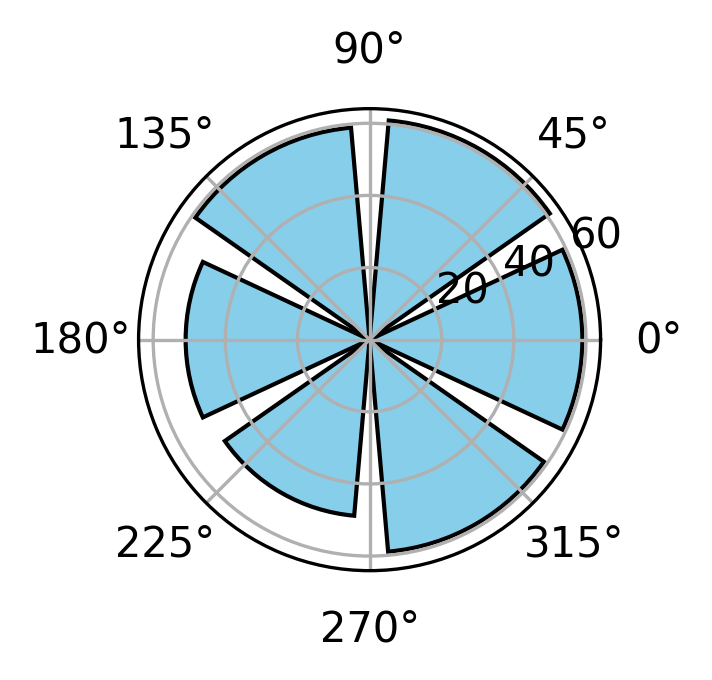

In [12]:
plot_solenoid_angle_distribution(M061_data[0]['data'])

## Prepare data for classifier

In [13]:
def restrict_time_interval(df, brain_areas, bin_start, length):
    interval_df = df.copy()
    interval_df[brain_areas] = df[brain_areas].apply(lambda row: row.apply(lambda arr: arr[bin_start:bin_start+length, :]))
    interval_df['trial_length'] = length
    return interval_df

def concat_and_pca(df, brain_areas):
    # concat trials
    concat_data = []
    for area in brain_areas:
        data = pyal.concat_trials(df, area)
        concat_data.append(data)
    
    # pca and reverse concat
    n_dim = 50
    reverse_concat_data = []
    for data in concat_data:
        pca = PCA(n_components = n_dim)
        pc_data = pca.fit_transform(data)
        reverse_data = pyal.reverse_concat(pc_data, df)
        reverse_concat_data.append(reverse_data)

    return reverse_concat_data

def label_data(df, pca_data, categories):
    labeled_data = []
    for data in pca_data:
        data_dict = {cat:[] for cat in categories}
        for cat in categories:
            for index, row in df.iterrows():
                if df.solenoid_angle[index] == cat:
                    data_dict[cat].append(data[index])
                    
        labeled_data.append(data_dict)

    return labeled_data

In [14]:
def pre_decoder_processing(labeled_data, categories):
    reshaped_data = []
    for X_data in labeled_data:
        # shuffle within each category
        data_X = shuffle_data(X_data, categories)
        # get minimum sample
        min_samples = minimum_samples(data_X, categories)
        # chop to minimum samples and concat for X and y data
        X_balanced_reshaped, y_balanced_reshaped = balance_and_reshape(data_X, categories, min_samples)
        # return lists ready for train-test split
        reshaped_data.append([X_balanced_reshaped, y_balanced_reshaped])
        
    return reshaped_data

def shuffle_data(df, categories):
    for cat in categories:
        random.shuffle(df[cat])
    return df

def minimum_samples(df, categories):
    min_samples = min(len(df[cat]) for cat in categories)
    return min_samples

def balance_and_reshape(X_data, categories, min_samples):
    # chop to min_sample size and combine
    X_balanced = []
    y_balanced = []
    for cat in categories:
        X_balanced.append(X_data[cat][0:min_samples])
        y_balanced.append(np.full(min_samples, cat))

    # concatenate all together
    X_balanced = np.concatenate(X_balanced, axis=0)
    y_balanced = np.concatenate(y_balanced, axis=0)

    # convert to 2d array (needed for the NB classifier)
    X_balanced_reshaped = np.array(X_balanced.reshape(len(X_balanced), -1))
    y_balanced_reshaped = np.array(y_balanced.reshape(len(y_balanced), -1))

    return [X_balanced_reshaped, y_balanced_reshaped]

In [15]:
def decode_and_score(clf, X_balanced_reshaped, y_balanced_reshaped, test_size, k_splits):
    X_train, X_test, y_train, y_test = train_test_split(X_balanced_reshaped, y_balanced_reshaped, test_size=0.1, random_state=0)
    # train classifier
    clf.fit(X_train, y_train.ravel())
    # make predictions
    predictions_control = clf.predict(X_train)
    predictions = clf.predict(X_test)
    # calculate accuracy
    accuracy_control = accuracy_score(y_train, predictions_control)
    # print(f"Control accuracy score on training data: {accuracy_control}")
    accuracy = accuracy_score(y_test, predictions)
    # print(f"Test set ({test_size*100}% of data) accuracy: {accuracy}")
    # k-fold validation
    kf = KFold(n_splits=k_splits, shuffle=True, random_state=44)
    # Perform k-fold cross-validation
    scores = cross_val_score(clf, X_balanced_reshaped, y_balanced_reshaped.ravel(), cv=kf)
    # print(f"Mean k-fold score: {np.mean(scores)}")
    return clf, scores

def classify(reshaped_data, test_size = 0.1, k_splits = 6):
    scores = []
    for data in reshaped_data:
        X_data, y_data = data

        clf = GaussianNB()
        clf, score = decode_and_score(clf, X_data, y_data, test_size, k_splits)
        scores.append(score)
    return scores

In [16]:
def naive_bayes_classifier(data, start_time, length):
    df_interval = restrict_time_interval(data['data'], data['brain_areas'], start_time, length)

    pca_data = concat_and_pca(df_interval, data['brain_areas'])

    labeled_data = label_data(df_interval, pca_data, data['categories'])

    reshaped = pre_decoder_processing(labeled_data, data['categories'])

    classifier_scores = classify(reshaped, test_size = 0.1, k_splits = 6)

    return classifier_scores

In [17]:
chance_level_m044 = 1 / len(M044_data['categories'])
chance_level = 1 / len(M061_data[0]['categories'])

### Testing different window lengths

In [18]:
# colour_scheme = ["#3681D2", "#8ed74d", "#a6a6a6"]
# colour_scheme = ["#3681D2", "#ff9d4d", "#8ed74d", '#e76f51', '#bbbbbb']
colour_scheme = [
    plt.cm.Blues(0.5),    # first brain area
    plt.cm.YlOrBr(0.5),   # second
    plt.cm.YlGn(0.5),     # third
    plt.cm.Reds(0.5),     # fourth
    "#bbbbbb"             # fifth (gray)
]

In [19]:
window_lengths = np.arange(1, 106, 1)
start_time = M061_data[0]['perturb_time_idx']
scores = []
for window_length in window_lengths:
    score = naive_bayes_classifier(M061_data[0], start_time, window_length)
    scores.append(score)
scores = np.array(scores)

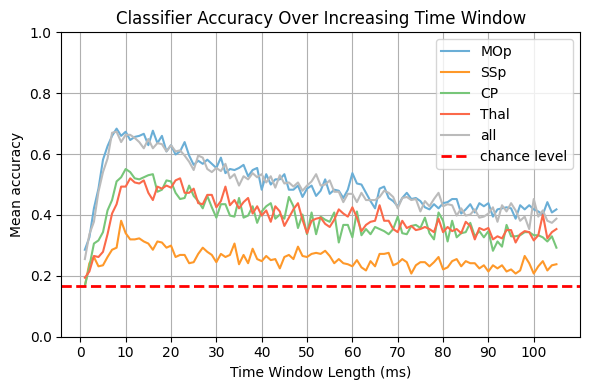

In [20]:
fig = plt.figure(figsize=(6, 4))

for cat in range(len(M061_data[0]['brain_areas'])):
    brain_area = M061_data[0]['brain_areas'][cat]
    area_scores = []

    for length in range(len(window_lengths)):
        mean_score = np.mean(scores[length][cat])  # Average over 6 folds
        area_scores.append(mean_score)

    plt.plot(window_lengths, area_scores, label=f"{brain_area.split('_')[0]}", color = colour_scheme[cat])

plt.axhline(y=chance_level, color='red', linestyle='--', linewidth=2, label=f'chance level')
plt.title("Classifier Accuracy Over Increasing Time Window")
plt.xlabel("Time Window Length (ms)")
plt.ylabel("Mean accuracy")
plt.xticks(np.arange(0, 106, 10))
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### Testing different start times

In [21]:
time_after_perturbation = np.arange(-20, 50, 1)
window_length = 10
scores_offset = []
for time_offset in time_after_perturbation:
    start_time = M061_data[0]['perturb_time_idx'] + time_offset
    score = naive_bayes_classifier(M061_data[0], start_time, window_length)
    scores_offset.append(score)
scores_offset = np.array(scores_offset)

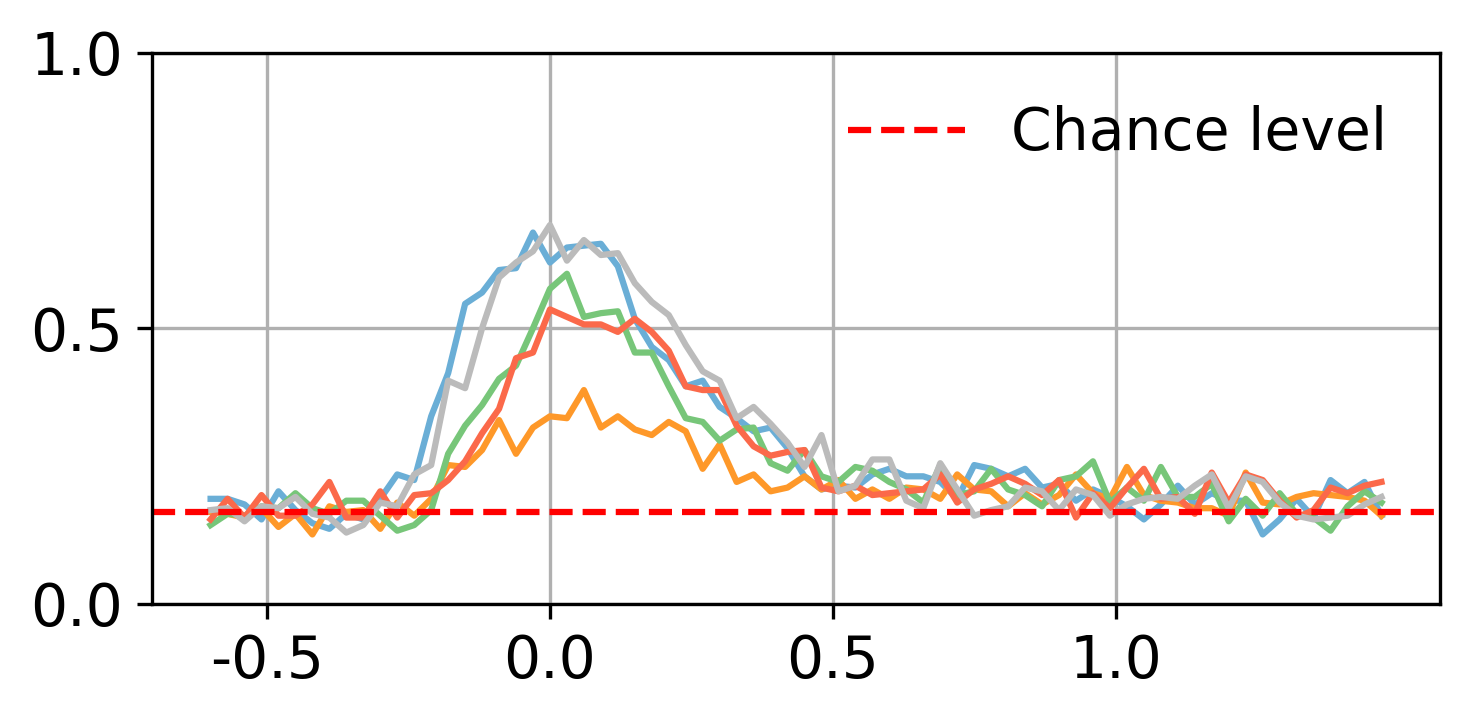

In [22]:
fig = plt.figure(figsize=(5, 2.5), dpi = 300)

bin_size = 0.03  # Each bin = 30 ms
time_in_seconds = np.array(time_after_perturbation) * bin_size

for cat in range(len(M061_data[0]['brain_areas'])):
    brain_area = M061_data[0]['brain_areas'][cat]
    area_scores = []

    for time in range(len(time_after_perturbation)):
        mean_score = np.mean(scores_offset[time][cat])  # Average over 6 folds
        area_scores.append(mean_score)

    plt.plot(time_in_seconds, area_scores,  color=colour_scheme[cat])

# Plot chance level line
plt.axhline(y=chance_level, color='red', linestyle='--', linewidth=1.5, label='Chance level')

# Axis labels and ticks
# plt.xlabel("Time offset from perturbation (s)", fontsize=14)
# plt.ylabel("Mean accuracy", fontsize=14)
plt.xticks(np.arange(-0.5, 1.5, 0.5), fontsize = 14)  # Adjust if needed
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.5), fontsize = 14)
plt.grid()

# Format tick labels to 1 decimal place
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}"))

# Legend
plt.legend(fontsize=14, loc='best', frameon = False)

plt.tight_layout()
plt.show()

## set window length and offset

In [23]:
window_length = 10
time_offset = 2

# M044

In [24]:
m044_scores = naive_bayes_classifier(M044_data, M044_data['perturb_time_idx']+time_offset, window_length)

## M061

In [25]:
M061_session0, M061_session1 = M061_data
m061_0_scores = naive_bayes_classifier(M061_session0, M061_session0['perturb_time_idx']+time_offset, window_length)
m061_1_scores = naive_bayes_classifier(M061_session1, M061_session1['perturb_time_idx']+time_offset, window_length)

## M062

In [26]:
M062_session0, M062_session1, M062_session2 = M062_data
m062_0_scores = naive_bayes_classifier(M062_session0, M062_session0['perturb_time_idx']+time_offset, window_length)
m062_1_scores = naive_bayes_classifier(M062_session1, M062_session1['perturb_time_idx']+time_offset, window_length)
m062_2_scores = naive_bayes_classifier(M062_session2, M062_session2['perturb_time_idx']+time_offset, window_length)

### Plot all sessions, based on brain area

In [27]:
print(len(m062_0_scores))

5


In [28]:
session_scores = {"M044": [m044_scores], "M061": [m061_0_scores, m061_1_scores], "M062": [m062_0_scores, m062_1_scores, m062_2_scores]}
area_labels = {"M044": ["MOp", "CP", "all"], 
               "M061": ["MOp","SSp", "CP", "VAL", "all", "MOp","SSp", "CP", "VAL", "all"], 
               "M062": ["MOp","SSp", "CP", "VAL", "all", "MOp","SSp", "CP", "VAL", "all", "MOp","SSp", "CP", "VAL", "all"]}

# get mean scores
mean_session_scores = {"M044": [], "M061": [], "M062": []}
for key, scores in session_scores.items():
    for area_scores in scores:
        for score in area_scores:
            mean_session_scores[key].append(np.mean(score))


In [29]:
# organize by brain area
brain_area_scores = {area: [] for area in ["MOp","SSp", "CP", "VAL", "all"]}
for mouse_label, scores in mean_session_scores.items():
    for idx in range(len(scores)):
        area_label = area_labels[mouse_label][idx]
        brain_area_scores[area_label].append(scores[idx])

In [30]:
curbd_colors = {'MOp': "#3681D2", 'SSp': "#ff9d4d", 'CP': "#8ed74d", 'VAL': '#e76f51', 'all': '#bbbbbb'}

data = []
for area, values in brain_area_scores.items():
    for val in values:
        data.append({'Brain Area': area, 'Mean score': val})
df_plot = pd.DataFrame(data)
df_plot.head()

,Brain Area,Mean score
0,MOp,0.372093
1,MOp,0.666667
2,MOp,0.519608
3,MOp,0.257862
4,MOp,0.326389


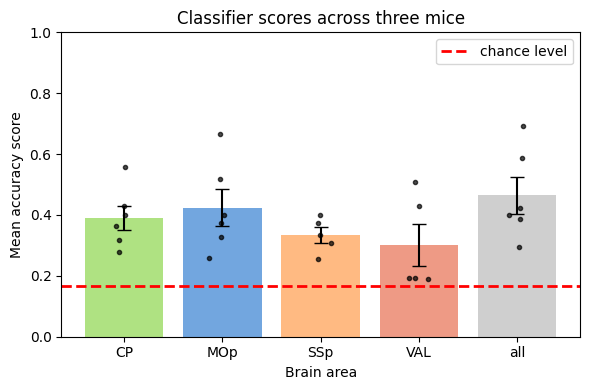

In [31]:
# Step 1: Compute summary stats
summary_df = df_plot.groupby('Brain Area')['Mean score'].agg(['mean', 'sem']).reset_index()

# Step 2: Use matplotlib bar chart with error bars
plt.figure(figsize=(6, 4))

x = np.arange(len(summary_df))
means = summary_df['mean']
sems = summary_df['sem']
areas = summary_df['Brain Area']
chance_level = 1 / len(M061_data[0]['categories'])

# Set colors
colors = [curbd_colors.get(area, '#cccccc') for area in areas]

# Plot bars
bars = plt.bar(x, means, yerr=sems, capsize=5, color=colors, alpha = 0.7)

# Step 3: Overlay individual data points
for i, area in enumerate(areas):
    y_points = df_plot[df_plot['Brain Area'] == area]['Mean score']
    x_points = np.random.normal(loc=i, scale=0.05, size=len(y_points))  # jitter
    plt.plot(x_points, y_points, 'o', color='black', alpha=0.7, markersize=3)

plt.axhline(y=chance_level, color='red', linestyle='--', linewidth=2, label=f'chance level')
plt.legend()
# Final touches
plt.xticks(x, areas)
plt.ylabel("Mean accuracy score")
plt.title("Classifier scores across three mice")
plt.ylim(0, 1)
plt.xlabel("Brain area")
plt.tight_layout()
plt.show()


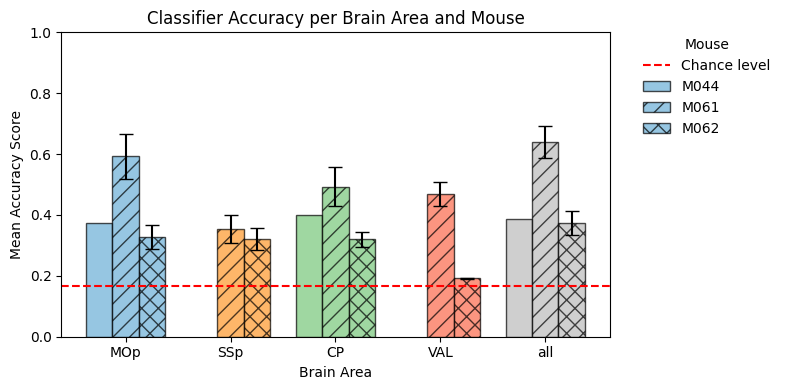

In [32]:
# 1. Build long-format DataFrame
data = []
for mouse, scores in mean_session_scores.items():
    for idx, score in enumerate(scores):
        area = area_labels[mouse][idx]
        data.append({'Mouse': mouse, 'Brain Area': area, 'Mean score': score})
df_plot = pd.DataFrame(data)

# Setup
brain_areas = ["MOp", "SSp", "CP", "VAL", "all"]
mice = ["M044", "M061", "M062"]
bar_width = 0.25
offsets = [-bar_width, 0, bar_width]

# Colors per brain area
# curbd_colors = {'MOp': "#3681D2", 'SSp': "#ff9d4d", 'CP': "#8ed74d", 'VAL': '#e76f51', 'all': '#bbbbbb'}
curbd_colors = {'MOp':plt.cm.Blues(0.5), 'SSp': plt.cm.YlOrBr(0.5), 'CP':plt.cm.YlGn(0.5), 'VAL':plt.cm.Reds(0.5), 'all': '#bbbbbb'}
# colour_scheme = [
#     plt.cm.Blues(0.5),    # first brain area
#     plt.cm.YlOrBr(0.5),   # second
#     plt.cm.YlGn(0.5),     # third
#     plt.cm.Reds(0.5),     # fourth
#     "#bbbbbb"             # fifth (gray)
# ]

# Hatch patterns per mouse
mouse_hatches = {'M044': '', 'M061': '//', 'M062': 'xx'}

# Prepare grouped stats
grouped = df_plot.groupby(['Brain Area', 'Mouse'])['Mean score'].agg(['mean', 'sem']).reset_index()

# Create figure
plt.figure(figsize=(8, 4))
x = np.arange(len(brain_areas))

# Plot bars
for i, mouse in enumerate(mice):
    means, sems, bar_colors, hatches = [], [], [], []
    for area in brain_areas:
        row = grouped[(grouped['Brain Area'] == area) & (grouped['Mouse'] == mouse)]
        if not row.empty:
            means.append(row['mean'].values[0])
            sems.append(row['sem'].values[0])
        else:
            means.append(np.nan)
            sems.append(0)
        bar_colors.append(curbd_colors.get(area, '#cccccc'))
        hatches.append(mouse_hatches[mouse])

    bars = plt.bar(x + offsets[i], means, yerr=sems, width=bar_width,
                   color=bar_colors, capsize=5, edgecolor='black', label=mouse, alpha = 0.7)
    
    # Apply hatches
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

# Chance line
chance_level = 1 / len(M061_data[0]['categories'])
plt.axhline(y=chance_level, color='red', linestyle='--', linewidth=1.5, label='Chance level')

# Axes and legend
plt.xticks(x, brain_areas)
plt.xlabel("Brain Area")
plt.ylabel("Mean Accuracy Score")
plt.title("Classifier Accuracy per Brain Area and Mouse")

# Legend outside
plt.legend(title="Mouse", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False)

plt.tight_layout()
plt.ylim(0, 1)
plt.show()

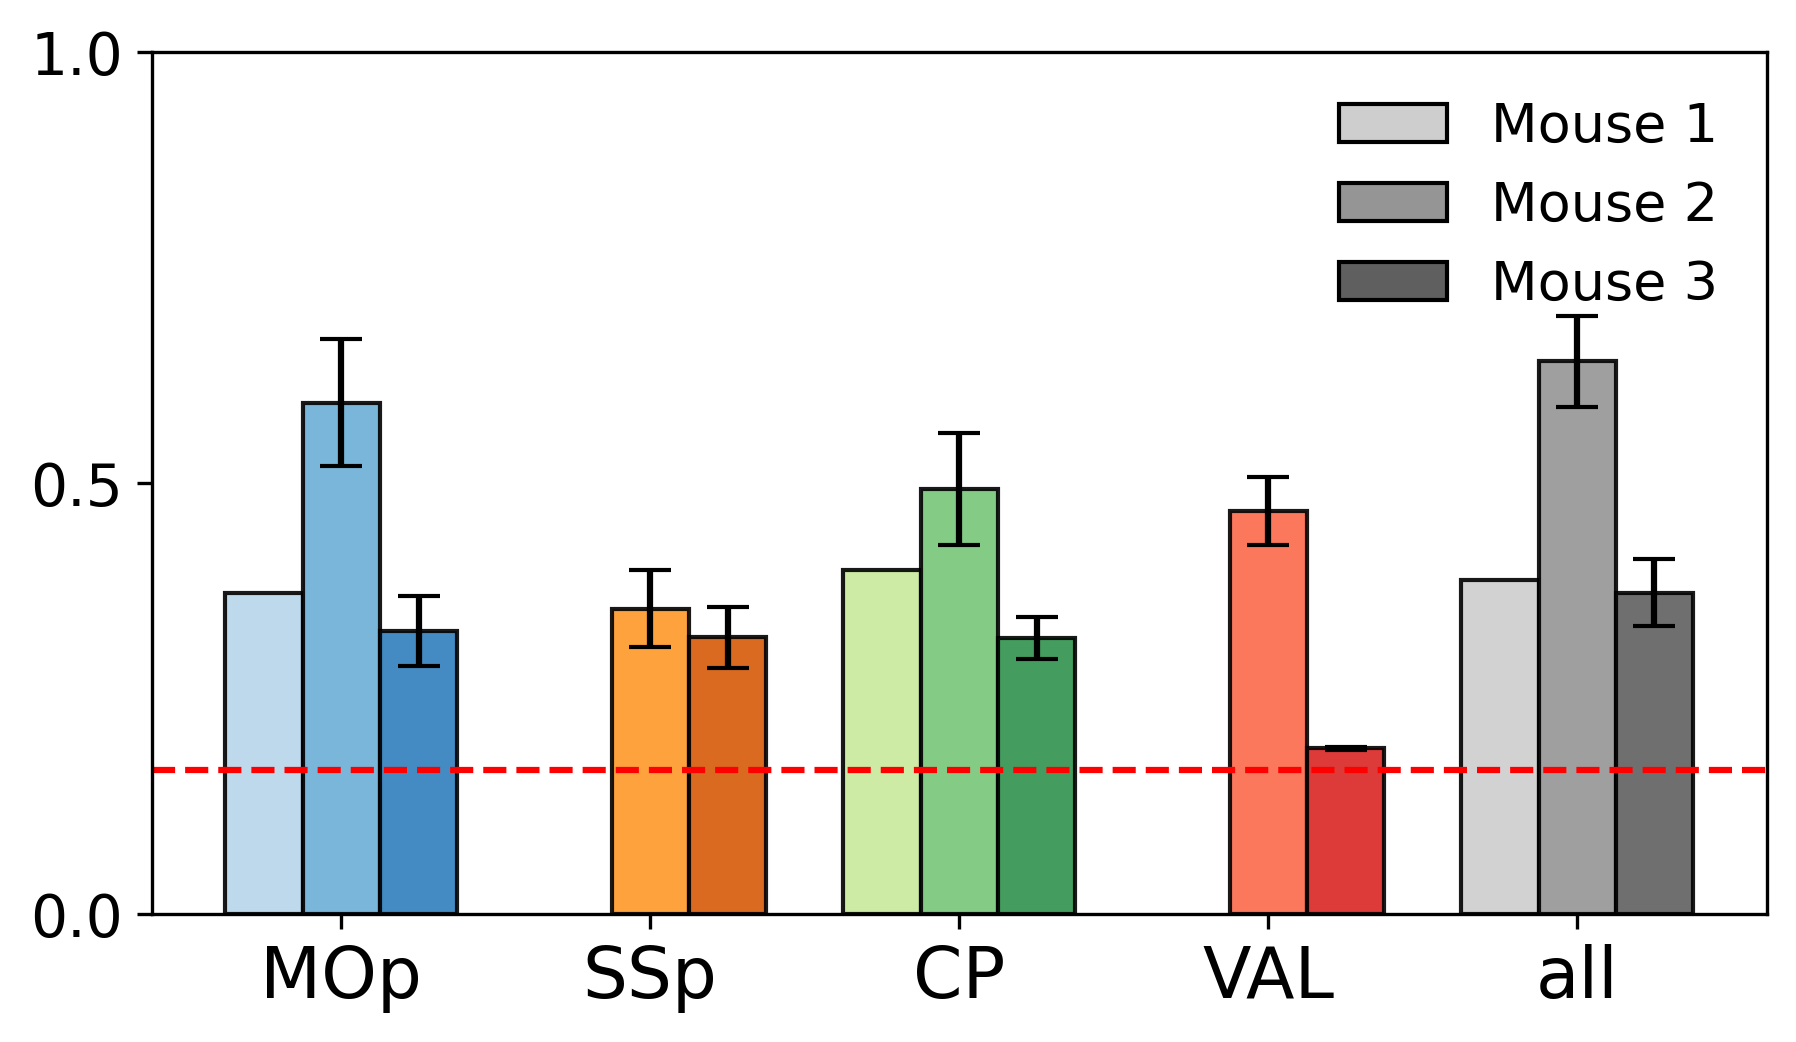

In [48]:
from matplotlib.patches import Patch
# 1. Build long-format DataFrame
data = []
for mouse, scores in mean_session_scores.items():
    for idx, score in enumerate(scores):
        area = area_labels[mouse][idx]
        data.append({'Mouse': mouse, 'Brain Area': area, 'Mean score': score})
df_plot = pd.DataFrame(data)

# Setup
brain_areas = ["MOp", "SSp", "CP", "VAL", "all"]
mice = ["M044", "M061", "M062"]
mouse_labels = {'M044': 'Mouse 1', 'M061': 'Mouse 2', 'M062': 'Mouse 3'}
bar_width = 0.25
offsets = [-bar_width, 0, bar_width]

# Color shades per mouse
mouse_shades = {'M044': 0.3, 'M061': 0.5, 'M062': 0.7}

# Colormaps for brain areas
area_cmaps = {
    'MOp': plt.cm.Blues,
    'SSp': plt.cm.YlOrBr,
    'CP': plt.cm.YlGn,
    'VAL': plt.cm.Reds,
    'all': plt.cm.Greys  # now variable grey
}

# Group data
grouped = df_plot.groupby(['Brain Area', 'Mouse'])['Mean score'].agg(['mean', 'sem']).reset_index()

# Create plot
plt.figure(figsize=(6, 3.5), dpi = 300)
x = np.arange(len(brain_areas))

# Plot bars
legend_patches = []
for i, mouse in enumerate(mice):
    means, sems, bar_colors = [], [], []
    for area in brain_areas:
        row = grouped[(grouped['Brain Area'] == area) & (grouped['Mouse'] == mouse)]
        if not row.empty:
            means.append(row['mean'].values[0])
            sems.append(row['sem'].values[0])
        else:
            means.append(np.nan)
            sems.append(0)

        cmap = area_cmaps[area]
        color = cmap(mouse_shades[mouse])
        bar_colors.append(color)

    # Plot bars for mouse
    plt.bar(x + offsets[i], means, yerr=sems, width=bar_width,
            color=bar_colors, capsize=5, edgecolor='black', alpha=0.9)

    # Add custom patch for legend with "all" brain area's color (Greys)
    legend_color = plt.cm.Greys(mouse_shades[mouse])
    legend_patches.append(Patch(facecolor=legend_color, edgecolor='black', label=mouse_labels[mouse]))

# Chance line
chance_level = 1 / len(M061_data[0]['categories'])
plt.axhline(y=chance_level, color='red', linestyle='--', linewidth=1.5)

# Axes and titles
plt.xticks(x, brain_areas, fontsize = 17)
# plt.xlabel("Brain Area")
# plt.ylabel("Mean Accuracy Score")
# plt.title("Classifier Accuracy per Brain Area and Mouse")

# Custom legend
plt.legend(handles=legend_patches, loc='upper right', frameon=False, fontsize = 13)

plt.tight_layout()
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.5), fontsize = 14)
plt.show()

## PCA Trajectory plot 

In [52]:
import cmocean

def compute_avg_trajectory(data_dict):
    avg_trajectories = {}
    for angle, trials in data_dict.items():
        trials = np.array(trials)  # Shape: (n_trials, timepoints, PCs)
        if trials.size > 0:
            # Compute mean across trials (axis=0 assumes time-aligned data)
            avg_trajectories[angle] = np.mean(trials, axis=0)
    return avg_trajectories
    
def plot_avg_trajectory(ax, avg_traj, colors, title):
    linewidth=2.5
    s_start = 70  # start marker size
    s_end = 100   # end marker size
    for i, (angle, trajectory) in enumerate(avg_traj.items()):
        if trajectory.shape[0] > 0:
            ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2],
                    label=f"Angle {angle}", color=colors[i], linewidth=linewidth)
            ax.scatter(trajectory[0, 0], trajectory[0, 1], trajectory[0, 2],
                       color=colors[i], marker='o', s=s_start)
            ax.scatter(trajectory[-1, 0], trajectory[-1, 1], trajectory[-1, 2],
                       color=colors[i], marker='x', s=s_end)

    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_zticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    # ax.grid(False)

    # # ax.xaxis.pane.fill = False
    # # ax.yaxis.pane.fill = False
    # # ax.zaxis.pane.fill = False
    # ax.view_init(elev=25, azim=45)

    # ax.set_xlabel("PC1")
    # ax.set_ylabel("PC2")
    # ax.set_zlabel("PC3")
    ax.set_title(title.split("_")[0])


def plt_pca(labeled_data, df_data):
    avg_trajectories = [compute_avg_trajectory(data) for data in labeled_data]

    fig = plt.figure(figsize=(8, 8), dpi = 300)
    colors = cmocean.cm.ice(np.linspace(0, 1, len(df_data['categories'])))
    colors = [plt.cm.Blues(np.linspace(0, 1, len(df_data['categories']))),
              plt.cm.YlOrBr(np.linspace(0, 1, len(df_data['categories']))),
              plt.cm.YlGn(np.linspace(0, 1, len(df_data['categories']))),
              plt.cm.Reds(np.linspace(0, 1, len(df_data['categories']))),]

    axes = []
    num_plots = len(avg_trajectories)
    rows, cols = 2, 2

    for i in range(rows * cols):
        ax = fig.add_subplot(rows, cols, i + 1, projection='3d')
        if i < num_plots:
            brain_area_label = df_data['brain_areas'][i]
            plot_avg_trajectory(ax, avg_trajectories[i], colors[i], brain_area_label)
            axes.append(ax)
        else:
            ax.axis('off')  # Hide unused subplot

    # # Add legend outside the plot
    # handles, labels = axes[-1].get_legend_handles_labels()
    # if handles:
    #     fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.8, 0.2), frameon=False)

    fig.tight_layout()
    plt.show()


In [53]:
def pca_trajectories(data, start_time, length):
    df_interval = restrict_time_interval(data['data'], data['brain_areas'], start_time, length)

    pca_data = concat_and_pca(df_interval, data['brain_areas'])

    labeled_data = label_data(df_interval, pca_data, data['categories'])

    plt_pca(labeled_data, data)
    return labeled_data

/tmp/ipykernel_57127/3495028075.py:72: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


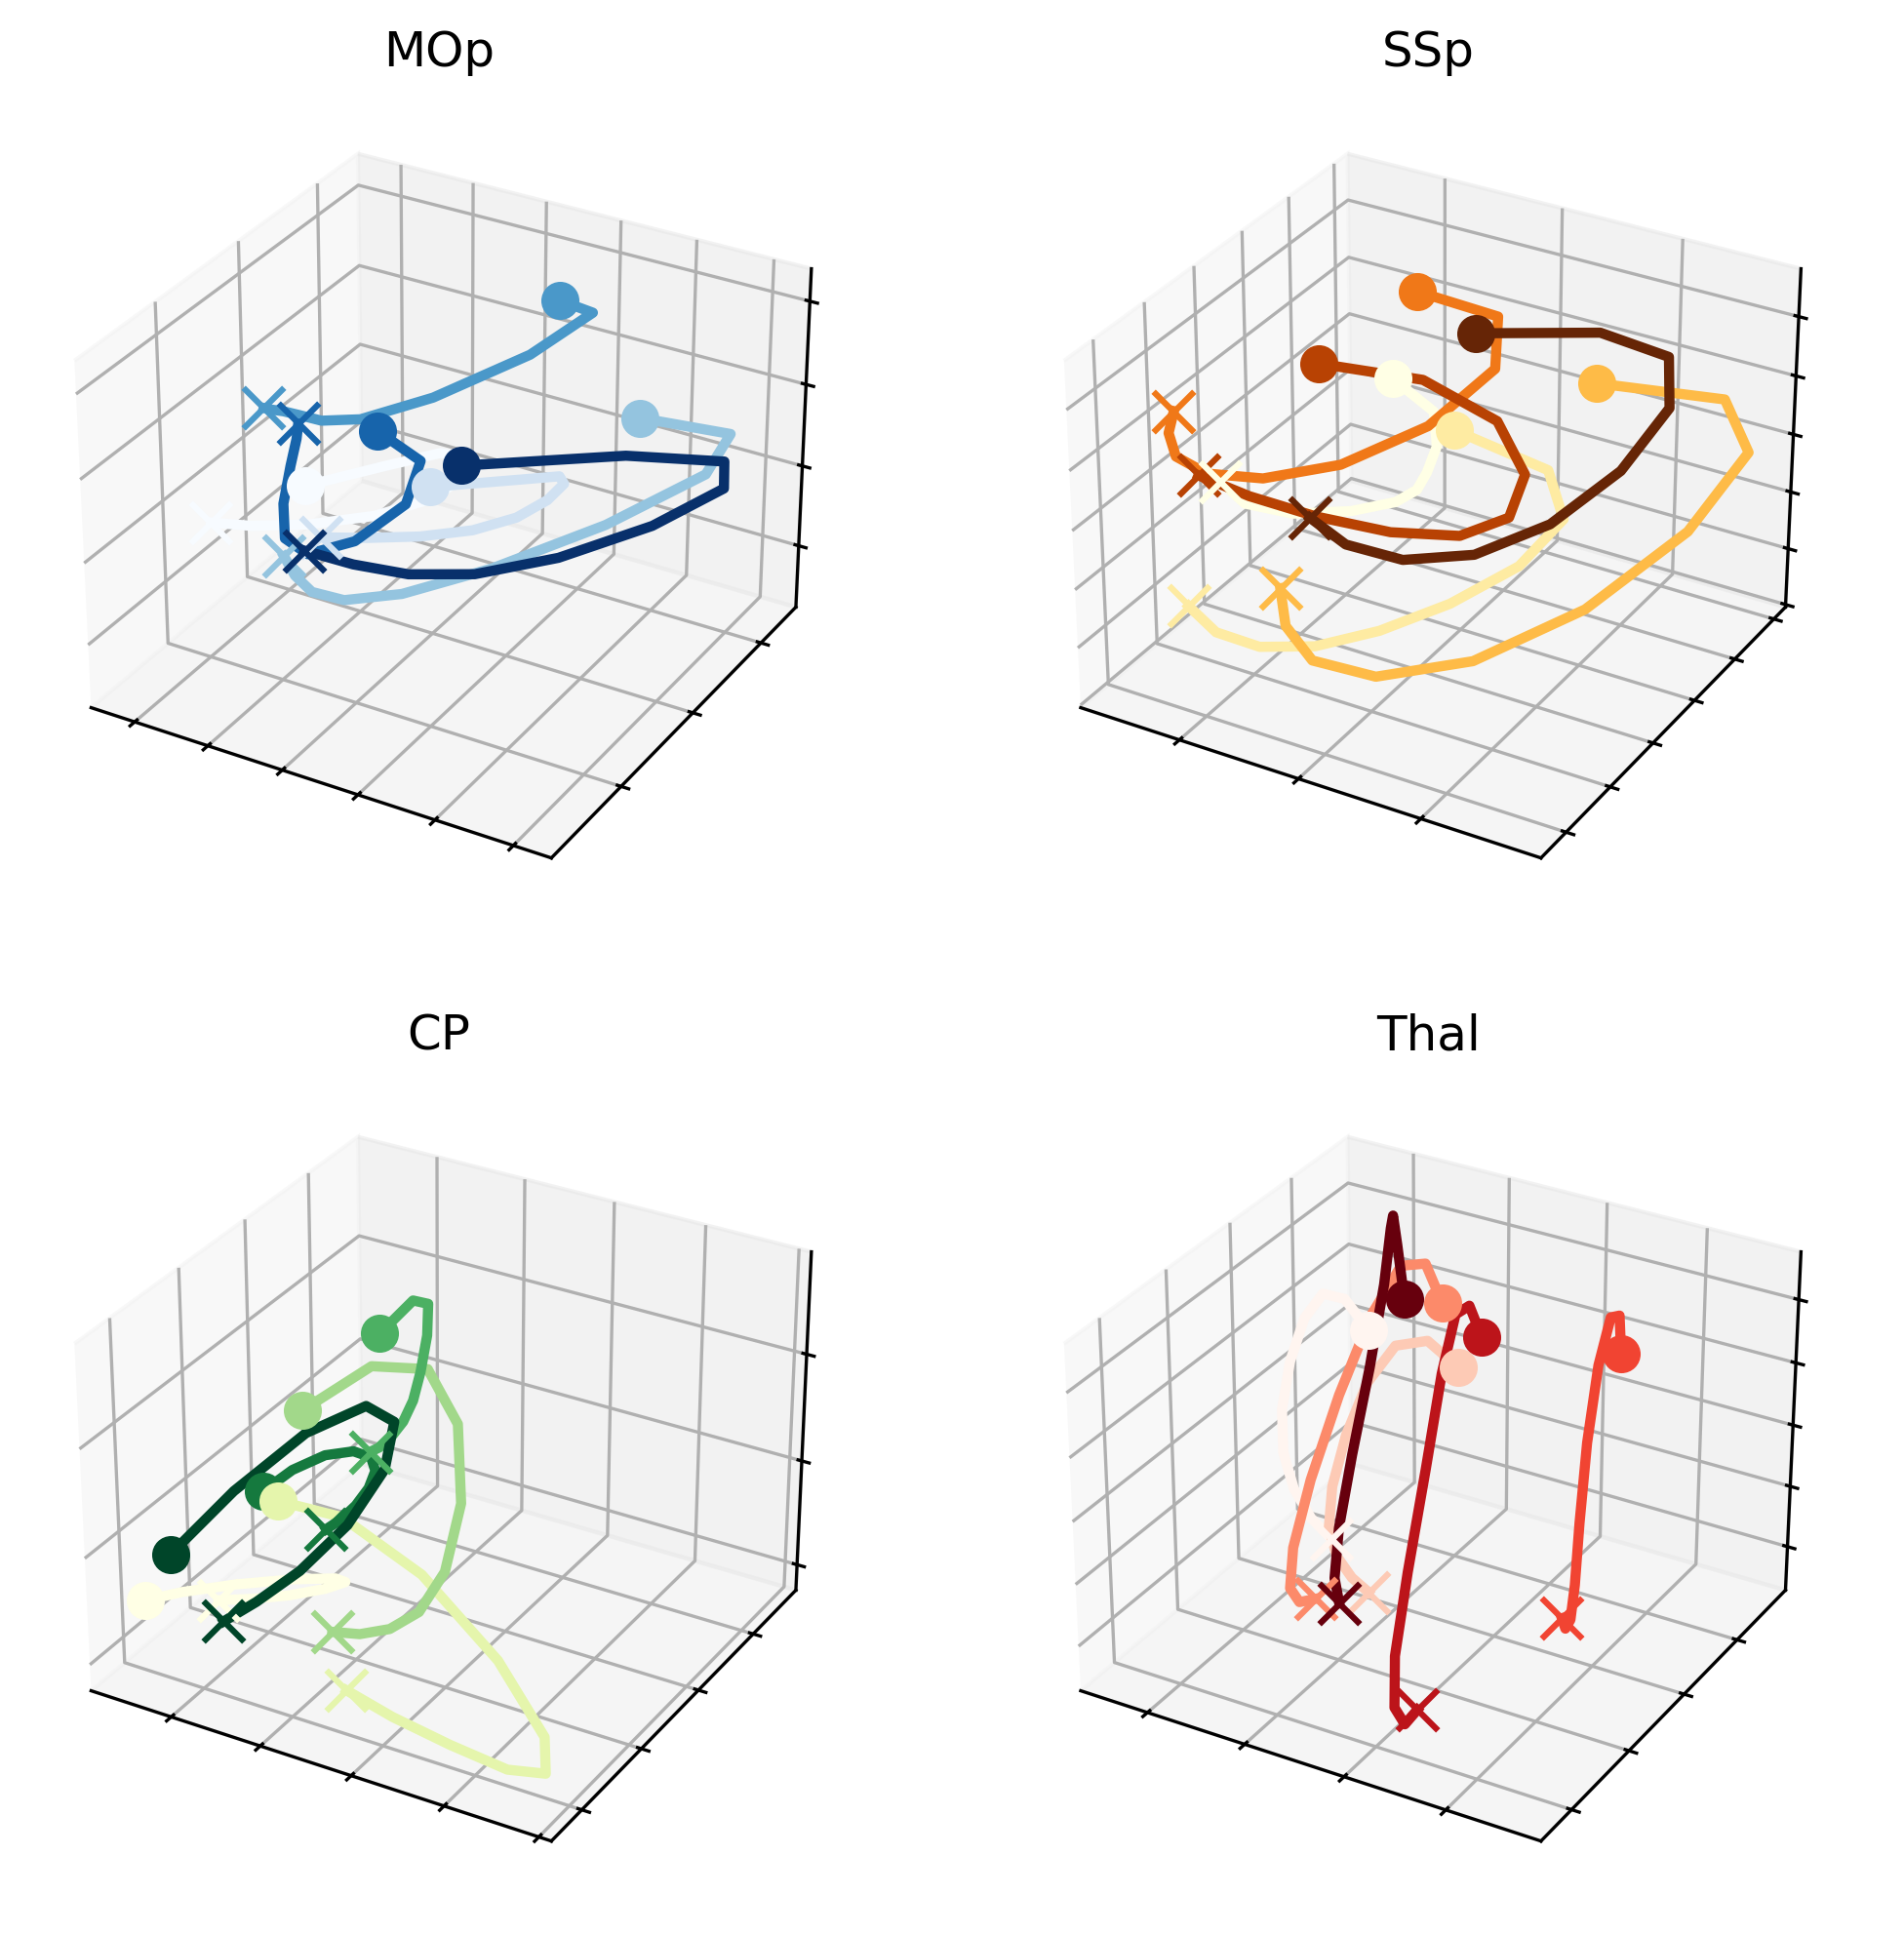

In [54]:
m061_labeled_data = pca_trajectories(M061_data[0], M061_data[0]['perturb_time_idx']+time_offset, window_length)